# PREPARE DATASETS FOR DOWNSTREAM ANALYSES

This Jupyter Notebook contains main functions to prepare gut microbiome time series data for downstream analyses.
1. Interpolate data using PCHIP interpolation function
2. Rarefy interpolated data to chosen treshold
3. Re-interpolate timepoints that got removed during the rarefaction step

#### Reguirements

We recommend running this conde inside a conda environment with qiime2 package installed

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate
import qiime2
from qiime2 import Metadata
from qiime2.plugins.feature_table.methods import rarefy
from qiime2.plugins.diversity.visualizers import alpha_rarefaction
from biom.table import Table

### Read dataframes

In [4]:
wd =  '/home/zuzannak/dynamo-main/data/'

/home/zuzannak/dynamo-main/whole_community_analysis


In [6]:
# male
male_df = pd.read_csv(wd + 'raw_files/male_assigned_sample_names.csv', 
                      index_col = [0]).sort_index()
# female
female_df = pd.read_csv(wd + 'raw_files/female_assigned_sample_names.csv', 
                        index_col = [0]).sort_index()
# donorA
donorA_df = pd.read_csv(wd + 'raw_files/donorA_assigned_sample_names.csv', 
                        index_col = [0]).iloc[:-1].sort_index() #remove last row as is Nan
donorA_df.index = donorA_df.index.astype(int) 
donorA_df = donorA_df[~donorA_df.index.duplicated(keep=False)]

# donorB
donorB_df = pd.read_csv(wd + 'raw_files/donorB_assigned_sample_names.csv', 
                        index_col = [0]).iloc[:-1].sort_index() #remove last observation as is the gape is too big t be interpolated
donorB_df.index = donorB_df.index.astype(int)
donorB_df = donorB_df[~donorB_df.index.duplicated(keep=False)]

In [7]:
def plot_missing_timepoints(data):
    
    data_idx = data.index
    df = pd.DataFrame([i for i in range(data_idx.max())], columns = ['day'])
    df['missing'] = np.where(df['day'].isin(data_idx), 0, 1)
    df['value'] = 1

    return df

In [8]:
male_missing = plot_missing_timepoints(male_df)
female_missing = plot_missing_timepoints(female_df)
donorA_missing = plot_missing_timepoints(donorA_df)
donorB_missing = plot_missing_timepoints(donorB_df)

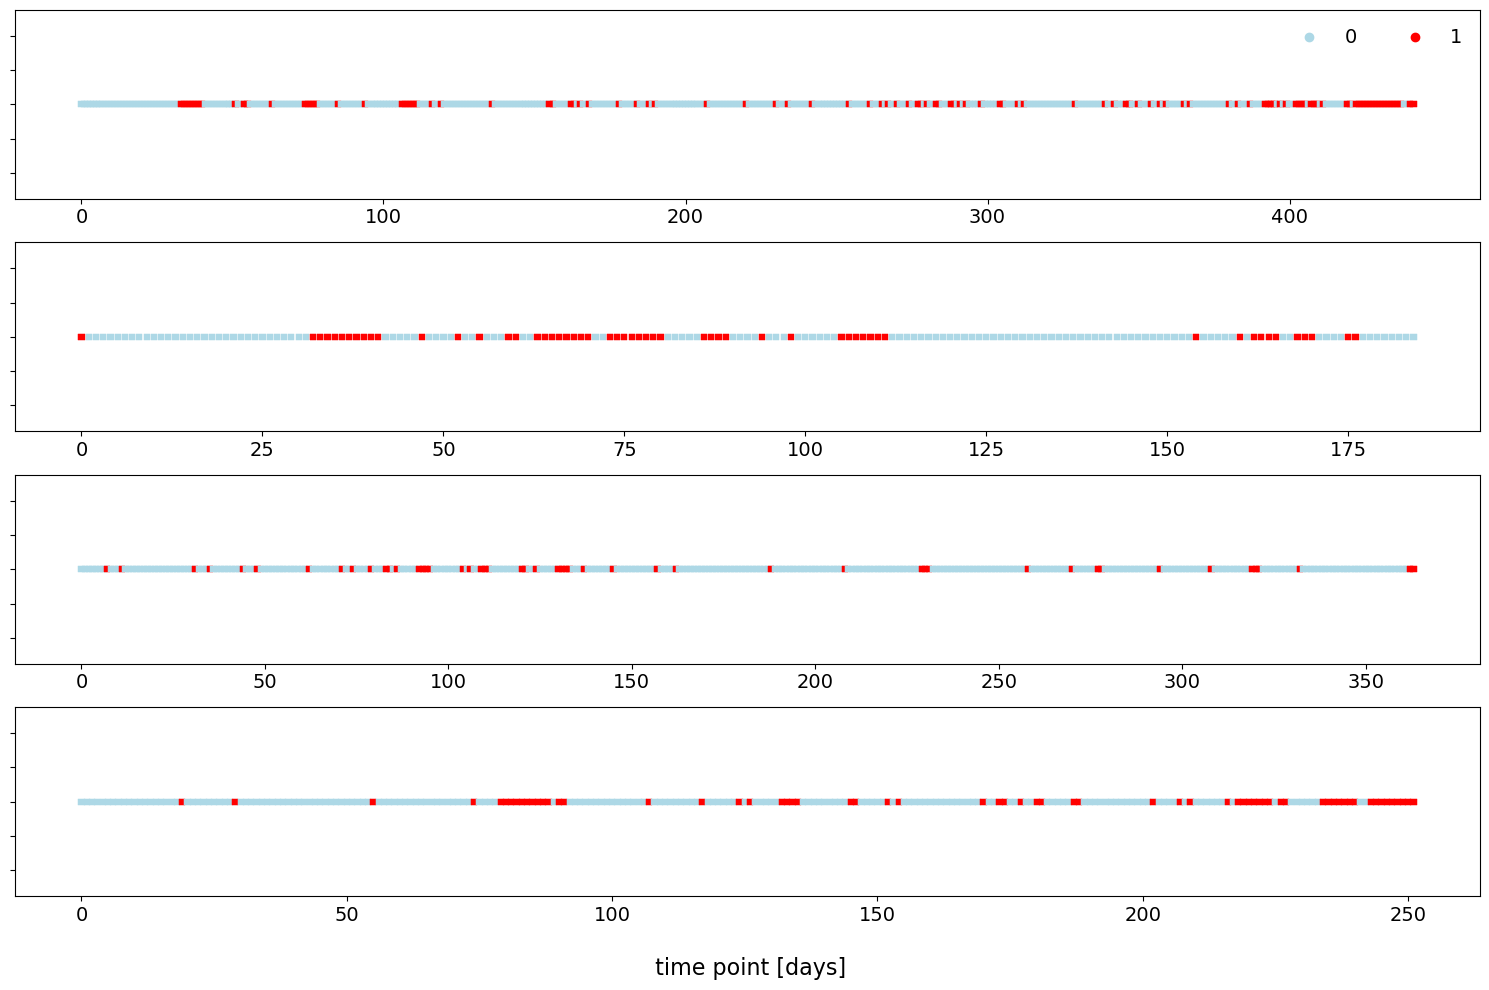

In [9]:
fig, axes = plt.subplots(4, 1, figsize = (15, 10))

sns.scatterplot(data = male_missing, x = 'day', y = 'value', hue = 'missing', palette = {0:'lightblue', 1:'red'}, edgecolor = None, s=20, marker='s', ax=axes[0])
sns.scatterplot(data = female_missing, x = 'day', y = 'value', hue = 'missing', palette = {0:'lightblue', 1:'red'}, edgecolor = None, s=20, marker='s', ax=axes[1], legend=False)
sns.scatterplot(data = donorA_missing, x = 'day', y = 'value', hue = 'missing', palette = {0:'lightblue', 1:'red'}, edgecolor = None, s=20, marker='s', ax=axes[2], legend=False)
sns.scatterplot(data = donorB_missing, x = 'day', y = 'value', hue = 'missing', palette = {0:'lightblue', 1:'red'}, edgecolor = None, s=20, marker='s', ax=axes[3], legend=False)

axes[0].legend(edgecolor = 'white',ncol=3, fontsize=14)

for i in range(4):
    axes[i].axes.yaxis.set_ticklabels([])
    axes[i].set_ylabel(None)
    axes[i].tick_params(axis='x', labelsize=14)

    if i == 3:
        axes[i].set_xlabel('\n time point [days]', size=16)
    else:
        axes[i].set_xlabel(None)
        
plt.tight_layout()
#plt.savefig('/Users/zkarwowska/Desktop/dynamo/missing_timepoints.png', dpi=300)

### Interpolate data using PCHIP

In [10]:
def prepare_data_for_interpolation(df):
        
    start_df = df.iloc[0].name
    end_df = df.iloc[-1].name

    full = list(range(start_df, end_df)) 
    missing_tpoints = list(set(full) - set(df.index.astype(int)))
    missing_df = df.reindex(df.index.union(missing_tpoints))

    return missing_df
    
def pchip_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index 
    interpolated_nodes = tmp[tmp.isna()].index 

    y = pchip_interpolate(base_nodes,
                          tmp.dropna().values,
                          interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = y

    return df_interpolated

def apply_interpolation(df, interpolation_function):

    INTERPOLATED_COLUMNS = []
    for col in df.columns:
        interpolated_col = interpolation_function(col, df)
        INTERPOLATED_COLUMNS.append(interpolated_col)
    INTERPOLATED_DF = pd.concat(INTERPOLATED_COLUMNS, axis=1)

    return INTERPOLATED_DF
    
def interpolate_pchip(df, path, subject):

    df = prepare_data_for_interpolation(df)
    df_interpolated = apply_interpolation(df, pchip_interpolation)
    df_interpolated = df_interpolated.astype(int).T
    df_interpolated.to_csv(path + f'{subject}_interpolated.tsv', sep = '\t')     
    
    return df_interpolated

In [11]:
path = wd + 'first_interpolation_files/'
male_interpolated_df = interpolate_pchip(male_df, path, 'male')
female_interpolated_df = interpolate_pchip(female_df, path,  'female')
donorA_interpolated_df = interpolate_pchip(donorA_df, path, 'donorA')
donorB_interpolated_df = interpolate_pchip(donorB_df, path, 'donorB')

### Change tsv to biom format

### Rarefy

In [73]:
def get_rarefaction_curves(
    feature_table: pd.DataFrame,
    biom_file: pd.DataFrame,
    subject: str,
    output_dir,
    max_depth: int = 25000
) -> None:
    """
    Generate and save rarefaction curves for microbiome data using QIIME2.
    
    Parameters
    ----------
    feature_table : pd.DataFrame
        DataFrame containing the feature table with samples as columns
    biom_file : pd.DataFrame
        BIOM format feature table
    subject : str
        Subject identifier used for metadata and output file naming
    output_dir : str
        Directory path where the rarefaction curve visualization will be saved
    max_depth : int, optional
        Maximum rarefaction depth, defaults to 25000
        
    Returns
    -------
    None
        Saves the rarefaction curve visualization as a .qzv file

        
    """

    # Create metadata DataFrame
    metadata = pd.DataFrame({
        '#SampleID': feature_table.columns,
        'subject': subject
    }, dtype='str').set_index('#SampleID')
    
    # Convert to QIIME2 metadata format
    qiime2_metadata = Metadata(metadata)
    
    # Import feature table as QIIME2 artifact
    unrarefied_table = qiime2.Artifact.import_data(
        "FeatureTable[Frequency]",
        biom_file
    )
    
    # Generate rarefaction curves
    rarefaction_vis = alpha_rarefaction(
        table=unrarefied_table,
        max_depth=max_depth,
        metadata=qiime2_metadata
    )
    
    # Save visualization
    output_file = output_dir + f'{subject}.qzv'
    rarefaction_vis.visualization.save(str(output_file))
        
# Create rarefaction curves
get_rarefaction_curves(
    feature_table=male_interpolated_df,
    biom_file=male_biom_file,
    subject='male',
    output_dir = wd + '/rarefaction_curves/',
    max_depth=30000)

In [ ]:
male_biom_file = wd + 'biom_files/male_pchip_interpolated.biom'

get_rarefaction_curves(
    feature_table=male_interpolated_df,
    biom_file=male_biom_file,
    subject='male',
    output_dir = wd + '/rarefaction_curves/',
    max_depth=30000)

In [74]:
female_biom_file = wd + 'biom_files/female_pchip_interpolated.biom'

get_rarefaction_curves(
    feature_table=female_interpolated_df,
    biom_file=female_biom_file,
    subject='female',
    output_dir = wd + '/rarefaction_curves/',
    max_depth=30000)

In [75]:
donorA_biom_file = wd + 'biom_files/donorA_pchip_interpolated.biom'

get_rarefaction_curves(
    feature_table=donorA_interpolated_df,
    biom_file=donorA_biom_file,
    subject='donorA',
    output_dir = wd + '/rarefaction_curves/',
    max_depth=30000)

In [76]:
donorB_biom_file = wd + 'biom_files/donorB_pchip_interpolated.biom'

get_rarefaction_curves(
    feature_table=donorB_interpolated_df,
    biom_file=donorB_biom_file,
    subject='donorB',
    output_dir = wd + '/rarefaction_curves/',
    max_depth=30000)

### Rarefy using chosen treshold

In [6]:
def rarefy_table(biom_file):
    
    '''
    biom_file: path to biom file 
    
    '''
    
    unrarefied_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", biom_file)
    #rarefy
    rarefy_result = rarefy(table=unrarefied_table, sampling_depth=18000)
    rarefied_table = rarefy_result.rarefied_table
    rarefied_table_df = rarefied_table.view(pd.DataFrame)
    rarefied_table_df.index = rarefied_table_df.index.astype(int)
    return rarefied_table_df

In [77]:
from typing import Union, Optional
from pathlib import Path

def rarefy_table(
    biom_file: Union[str, Path],
    sampling_depth: int = 18000
) -> pd.DataFrame:
    """
    Rarefy a BIOM format feature table to a specified sampling depth.
    
    Parameters
    ----------
    biom_file : str or Path
        Path to the input BIOM format feature table file
    sampling_depth : int, default=18000
        Number of sequences to rarefy per sample
        
    Returns
    -------
    pd.DataFrame
        Rarefied feature table with features as rows and samples as columns.
        Feature IDs are converted to integers.
        
    Notes
    -----
    The function performs the following steps:
    1. Imports the BIOM file as a QIIME2 artifact
    2. Rarefies the table to the specified sampling depth
    3. Converts the rarefied table to a pandas DataFrame
    4. Ensures feature IDs are integers
    """
    # Import the BIOM file as a QIIME2 artifact
    unrarefied_table = qiime2.Artifact.import_data(
        "FeatureTable[Frequency]",
        biom_file
    )
    
    # Perform rarefaction
    rarefied_result = rarefy(
        table=unrarefied_table,
        sampling_depth=sampling_depth
    )
    
    # Extract the rarefied table
    rarefied_table = rarefied_result.rarefied_table
    
    # Convert to pandas DataFrame
    rarefied_df = rarefied_table.view(pd.DataFrame)
    
    # Convert feature IDs to integers
    rarefied_df.index = rarefied_df.index.astype(int)
    
    return rarefied_df

# Example usage:
"""
# Basic usage with default sampling depth
rarefied_data = rarefy_table('path/to/biom/file.biom')

# Specify custom sampling depth
rarefied_data = rarefy_table(
    biom_file='path/to/biom/file.biom',
    sampling_depth=20000
)
"""

In [79]:
male_rarefied_df = rarefy_table(male_biom_file)
female_rarefied_df = rarefy_table(female_biom_file)
donorA_rarefied_df = rarefy_table(donorA_biom_file)
donorB_rarefied_df = rarefy_table(donorB_biom_file)

### interpolate after rarefaction

In [80]:
def re_interpolate_pchip(df):
    
    '''
    df: rarefied dataframe
    '''

    df = prepare_data_for_interpolation(df)
    df_interpolated = apply_interpolation(df, pchip_interpolation)
    df_interpolated = df_interpolated.astype(int)
    
    return df_interpolated

reinterpolated_male_rarefied_df = re_interpolate_pchip(male_rarefied_df)
reinterpolated_female_rarefied_df = re_interpolate_pchip(female_rarefied_df)
reinterpolated_donorA_rarefied_df = re_interpolate_pchip(donorA_rarefied_df)
reinterpolated_donorB_rarefied_df = re_interpolate_pchip(donorB_rarefied_df)

### save as tsv and then change to biom format for further analyses

In [87]:
def to_csv(df, path, subject):
    df.T.to_csv(path + f'{subject}_rarefied_18000_interpolated_pchip.tsv', sep = '\t')
    
path = wd + 'ready_files/'

to_csv(reinterpolated_male_rarefied_df, path, 'male')
to_csv(reinterpolated_female_rarefied_df, path, 'female')
to_csv(reinterpolated_donorA_rarefied_df, path, 'donorA')
to_csv(reinterpolated_donorB_rarefied_df, path, 'donorB')